In [4]:
import numpy as np
import matplotlib.pyplot as plt
from lenstronomy.Cosmo.micro_lensing import einstein_radius
from calc_ellipticity_webb import ellipticity, ellipticity_image_mock
from astropy import units as u

In [5]:
deltaPix = 0.031
psf = 0.08              # useless in this case

## standard ellipticity and light curve

In [6]:
d_s = 8000
d_l = 4000              # pc
M0 = 500                # M_sol
u_min = 0.2
theta_E = einstein_radius(M0, d_l, d_s)     # arcsec
velocity = 400*u.km/u.s # km/s

d_lu = d_l*u.pc
tE = (theta_E*u.arcsec/(velocity/d_lu*u.rad)).to(u.day)

print(f'theta_E = {theta_E}')
print(f't_E = {tE}')

theta_E = 0.022563962332804187
t_E = 390.6852684655684 d


In [15]:
t = np.linspace(-tE.value, tE.value, 50)

b = theta_E*u_min                                 # let's assume the nearest position is 0.5 theta_E
beta = np.sqrt(b**2 + (t*u.day*velocity/d_lu*u.rad).to(u.arcsec).value**2)

theta_p = (beta + np.sqrt(beta*beta+4*theta_E*theta_E))/2
theta_n = (beta - np.sqrt(beta*beta+4*theta_E*theta_E))/2

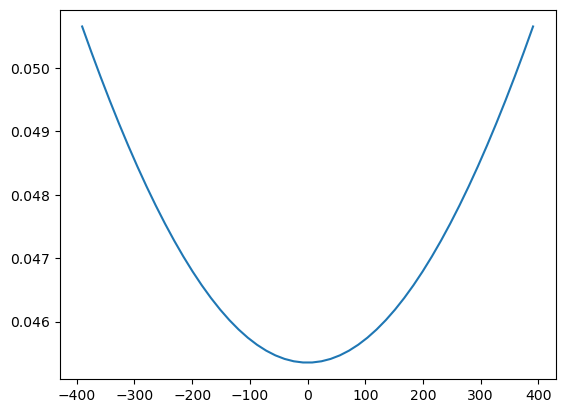

In [19]:
plt.plot(t, theta_p - theta_n)

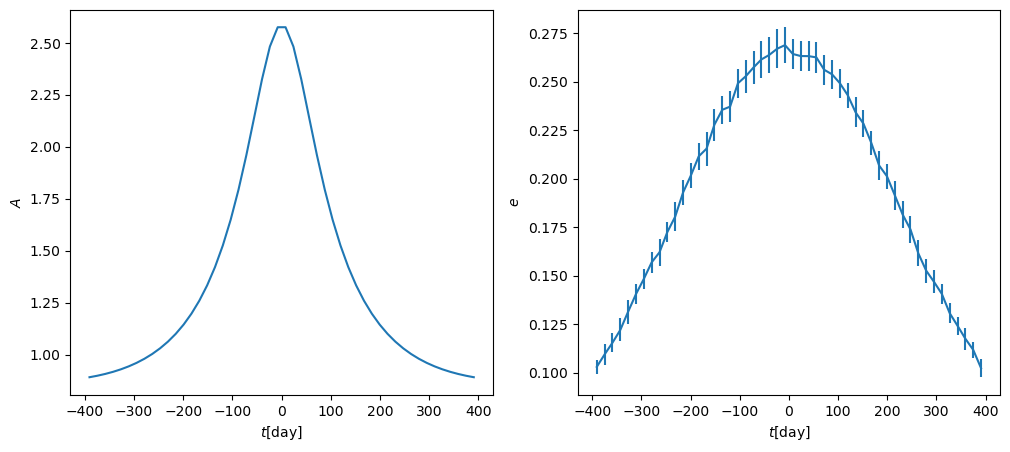

In [18]:
t = np.linspace(-tE.value, tE.value, 50)
b = theta_E*u_min                                 # let's assume the nearest position is 0.5 theta_E
beta = np.sqrt(b**2 + (t*u.day*velocity/d_lu*u.rad).to(u.arcsec).value**2) / theta_E

Amp = (beta*beta+1)/(beta*np.sqrt(beta*beta + 4))
ellip, err_ellip = ellipticity(deltaPix, psf, beta, theta_E=theta_E, use_galsim=True)

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(12, 5))

ax = axes[0]
ax.plot(t, Amp)
ax.set_xlabel('$t$[day]')
ax.set_ylabel('$A$')

ax = axes[1]
ax.errorbar(t, ellip, err_ellip)
ax.set_xlabel('$t$[day]')
ax.set_ylabel('$e$')

plt.show()

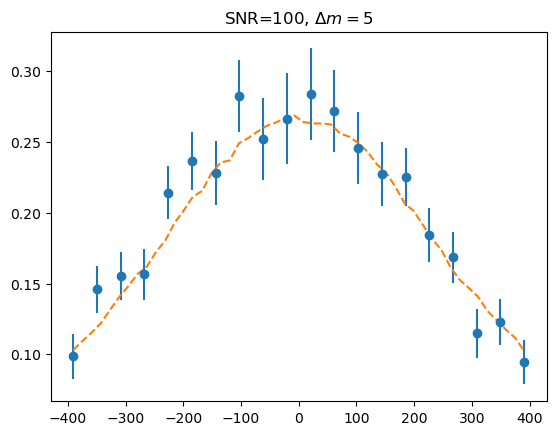

In [19]:
t_obs = np.linspace(-tE.value, tE.value, 20)
b = theta_E*u_min                                 # let's assume the nearest position is 0.5 theta_E
x = (t_obs*u.day*velocity/d_lu*u.rad).to(u.arcsec).value
e_obs = np.zeros_like(t_obs)
err_obs = np.zeros_like(t_obs)
ims = []
snr = 100
for i in range(len(t_obs)):
    res = ellipticity_image_mock(deltaPix, psf, 0, 0, x[i], b, theta_E, 100, True, True, snr, 1)
    e_obs[i] = res['e']
    err_obs[i] = res['e_err']
    ims.append(res['image'])
plt.errorbar(t_obs, e_obs, err_obs, fmt='o')
plt.plot(t, ellip, '--')

plt.title(rf'SNR={snr}, $\Delta m = 5$')
plt.show()

In [20]:
np.save('mock2_webb', [t_obs, e_obs, err_obs])

In [34]:
for i in range(len(t_obs)):
    np.save(f'./images/image_{int(t_obs[i])}', ims[i].array)

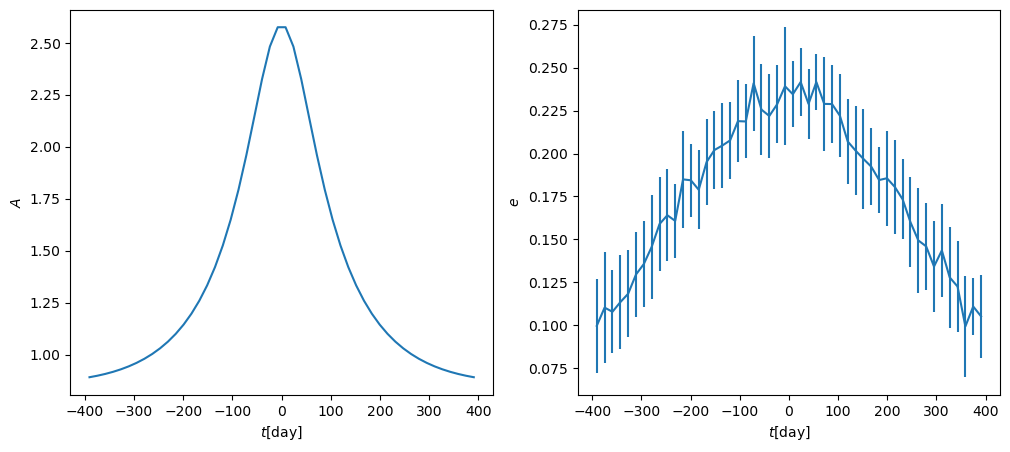

In [7]:
t = np.linspace(-tE.value, tE.value, 50)
b = theta_E*0.2                                 # let's assume the nearest position is 0.5 theta_E
beta = np.sqrt(b**2 + (t*u.day*velocity/d_lu*u.rad).to(u.arcsec).value**2) / theta_E

Amp = (beta*beta+1)/(beta*np.sqrt(beta*beta + 4))
ellip, err_ellip = ellipticity(deltaPix, psf, beta, theta_E=theta_E, use_galsim=True, add_noise=True, snr=50, sky_level=1)


fig, axes = plt.subplots(1, 2, sharex=True, figsize=(12, 5))

ax = axes[0]
ax.plot(t, Amp)
ax.set_xlabel('$t$[day]')
ax.set_ylabel('$A$')

ax = axes[1]
ax.errorbar(t, ellip, err_ellip)
ax.set_xlabel('$t$[day]')
ax.set_ylabel('$e$')

plt.show()

## curves of different M_h

Any of the $e-M_h(\text{or } d_l)$ relation can be interpreted as $e-\theta_E$ relation.
$$
\theta_E \propto M_h \frac{D_{ls}}{D_lD_s}\\
R_E \propto M_h \frac{D_{ls} D_l}{D_s}
$$
We can assume the peak value of Amplification is static, and the unknown is mainly velocity, mass, lens distance.

In [14]:
d_s = 8000
d_l = 4000                            # pc
M0 = np.linspace(50, 1000, 10)         # M_sol
Amps = []
ellips = []
err_ellips = []
for m in M0:
    theta_E = einstein_radius(m, d_l, d_s)     # arcsec
    b = theta_E*u_min                             # We fix b/theta_E, so that the peak amplification is the same
    beta = np.sqrt(b**2 + (t*u.day*velocity/d_lu*u.rad).to(u.arcsec).value**2) / theta_E
    Amp = (beta*beta+1)/(beta*np.sqrt(beta*beta + 4))
    ellip, err_ellip = ellipticity(deltaPix, psf, beta, theta_E=theta_E)
    Amps.append(Amp)
    ellips.append(ellip)
    err_ellips.append(err_ellip)

In [15]:
diff_velocity = np.linspace(200, 800, 10)
Amps_2 = []
ellips_2 = []
err_ellips_2 = []
m = 500
for v in diff_velocity:
    theta_E = einstein_radius(m, d_l, d_s)     # arcsec
    b = theta_E*u_min                             # We fix b/theta_E, so that the peak amplification is the same
    beta = np.sqrt(b**2 + (t*u.day*v*u.km/u.s/d_lu*u.rad).to(u.arcsec).value**2) / theta_E
    Amp = (beta*beta+1)/(beta*np.sqrt(beta*beta + 4))
    ellip, err_ellip = ellipticity(deltaPix, psf, beta, theta_E=theta_E)
    Amps_2.append(Amp)
    ellips_2.append(ellip)
    err_ellips_2.append(err_ellip)

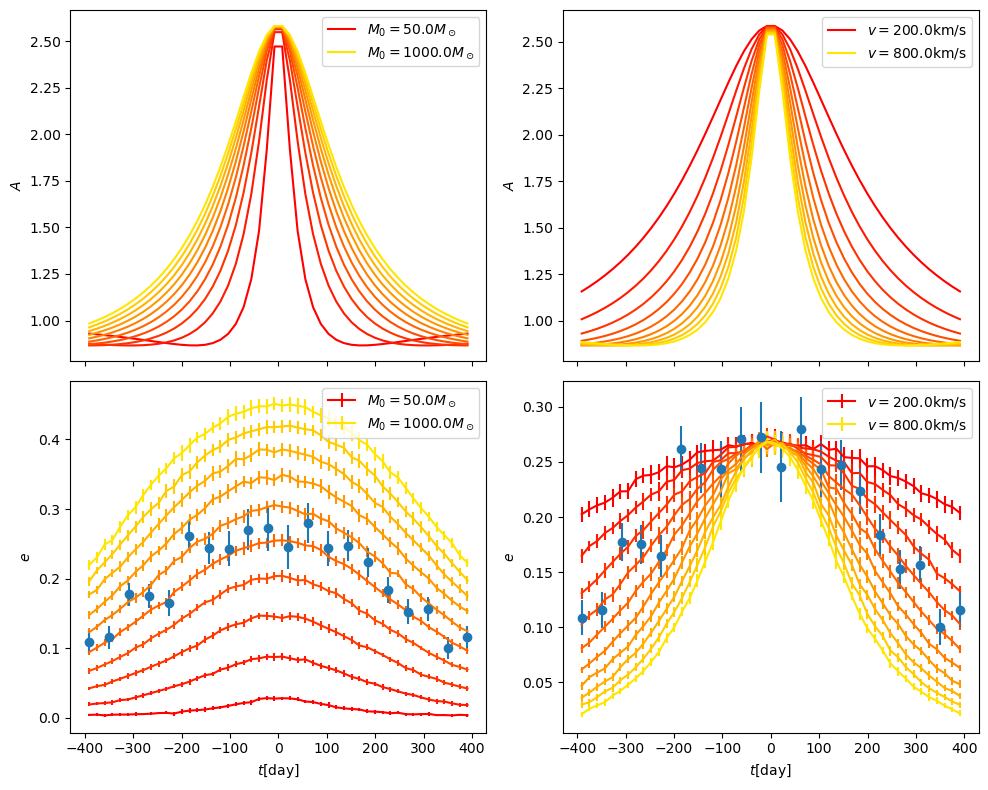

In [16]:
ht = lambda ls: [ls[0], ls[-1]]
cmap = plt.get_cmap('autumn')
fig, axes = plt.subplots(2, 2, sharex=True, figsize=(10, 8))

ax = axes[0,0]
for i in range(len(Amps)):
    ax.plot(t, Amps[i], label=f'$M_0={M0[i]} M_\\odot$', color=cmap(i/len(Amps)))
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=ht(handles), labels=ht(labels))
ax.set_ylabel('$A$')

ax = axes[0,1]
for i in range(len(Amps_2)):
    ax.plot(t, Amps_2[i], label=f'$v={diff_velocity[i]} \\mathrm{{km/s}}$', color=cmap(i/len(Amps_2)))
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=ht(handles), labels=ht(labels))
ax.set_ylabel('$A$')

ax = axes[1,0]
for i in range(len(ellips)):
    # ax.plot(t, ellips[i], label=f'$M_0={M0[i]} M_\\odot$', color=cmap(i/len(ellips)))
    ax.errorbar(t, ellips[i], err_ellips[i], label=f'$M_0={M0[i]} M_\\odot$', color=cmap(i/len(ellips)))
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=ht(handles), labels=ht(labels))
ax.errorbar(t_obs, e_obs, err_obs, fmt='o')
ax.set_xlabel('$t$[day]')
ax.set_ylabel('$e$')

ax = axes[1,1]
for i in range(len(ellips_2)):
    # ax.plot(t, ellips_2[i], label=f'$v={diff_velocity[i]} \\mathrm{{km/s}}$', color=cmap(i/len(ellips_2)))
    ax.errorbar(t, ellips_2[i], err_ellips_2[i], label=f'$v={diff_velocity[i]} \\mathrm{{km/s}}$', color=cmap(i/len(ellips_2)))
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=ht(handles), labels=ht(labels))
ax.errorbar(t_obs, e_obs, err_obs, fmt='o')

ax.set_xlabel('$t$[day]')
ax.set_ylabel('$e$')

plt.tight_layout()


plt.show()

## Examine the e, theta_E, beta relation

In [6]:
d_s = 8000
d_l = 4000              # pc
d_lu = d_l*u.pc
M0 = 500               # M_sol
theta_E0 = einstein_radius(M0, d_l, d_s)    # arcsec
# Base theta_E

beta0 = np.linspace(0.1, 1, 40)
theta_E = theta_E0*np.linspace(0.5, 1.5, 30)

beta_2, theta_E_2 = np.meshgrid(beta0, theta_E)

In [7]:
result = ellipticity(deltaPix, psf, beta=beta_2, theta_E=theta_E_2, use_galsim=False, verbose=True)

100%|██████████| 1200/1200 [00:33<00:00, 35.64it/s]


In [9]:
Amp = (beta0*beta0+1)/(beta0*np.sqrt(beta0*beta0 + 4))

In [17]:
plt.Axes.images

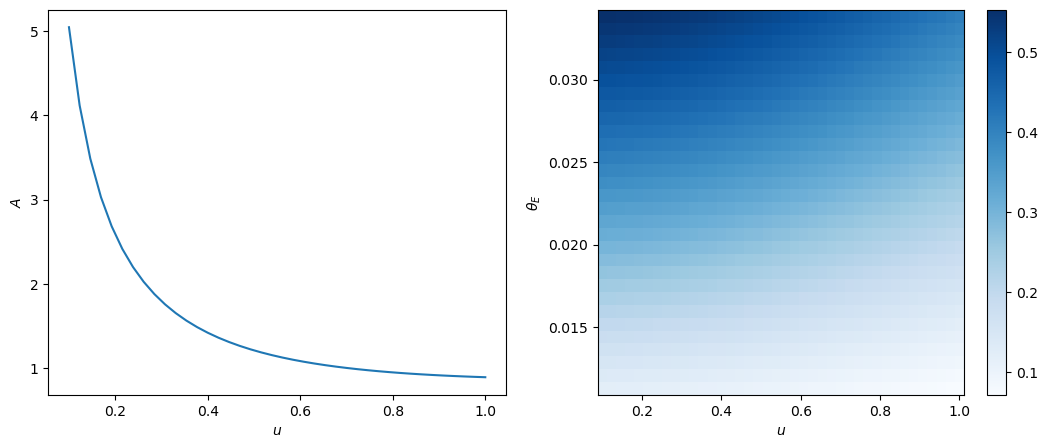

In [20]:
cmap = 'Blues'
fig, ax = plt.subplots(1, 2, figsize=(13, 5))
ax_l, ax_r = ax
ax_l.plot(beta0, Amp)
ax_l.set_xlabel('$u$')
ax_l.set_ylabel('$A$')
im = ax_r.pcolormesh(beta_2, theta_E_2, result[0], cmap=cmap)
ax_r.set_xlabel('$u$')
ax_r.set_ylabel('$\\theta_E$')
plt.colorbar(mappable=im, ax=ax_r)
plt.show()